In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
from collections import defaultdict
from tqdm.notebook import tqdm
from scipy.stats import mannwhitneyu, wilcoxon, spearmanr
from enum import Enum, auto
import plotly.graph_objects as go
from JOPLEn.singletask import JOPLEn, SquaredError
from JOPLEn.partitioner import GBPartition
from JOPLEn.enums import CellModel, NormType
from sklearn.ensemble import GradientBoostingRegressor
from copy import deepcopy
from sklearn.preprocessing import StandardScaler


CACHE_DIR = Path("ax_runs") / "prediction"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DS_PATH = Path("..") / "datasets" / "pmlb" / "processed"
PARAM_PATH = Path(".") / "parameters"
PLOT_PATH = Path(".") / "plots"

In [6]:
def count_categorical(arr: np.ndarray) -> float:
    """Counts the number of categorical, ordinal, binary, or nominal features"""
    return float(np.sum(np.all(np.mod(arr, 1) == 0, axis=0)))


def load_ds_info(ds_path, ds_type, model_name):
    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")

    n_categorical = count_categorical(x_train)

    return {
        "n_samples": int(x_train.shape[0]),
        "n_features": int(x_train.shape[1]),
        "n_categorical": int(n_categorical),
        "frac_categorical": float(n_categorical / x_train.shape[1]),
        "n_observations": int(x_train.shape[0]),
        "is_classification": ds_type == "class",
        "model_name": str(model_name),
        "contains_categorical": n_categorical > 0,
    }


def load_model_info(ds_path, ds_type, model_name):
    ds_name = ds_path.name

    dir_path = CACHE_DIR / ds_type / model_name / ds_name
    metadata_path = dir_path / "metadata.yaml"

    if metadata_path.exists():
        with open(metadata_path) as f:
            return yaml.load(f, Loader=yaml.FullLoader)
    else:
        return None

In [7]:
reg_datasets = [d for d in (DS_PATH / "reg").iterdir() if d.is_dir()]
class_datasets = [d for d in (DS_PATH / "class").iterdir() if d.is_dir()]

In [9]:
dataset_info = {}
model_info = defaultdict(lambda: defaultdict(dict))

for name, lst in zip(["regr", "class"], [reg_datasets, class_datasets]):
    print(f"Loading {name} models")

    dirs = [d for d in (CACHE_DIR / name).iterdir() if d.is_dir()]

    for model_path in tqdm(dirs):
        model_name = model_path.name
        for ds_path in lst:
            res = load_model_info(ds_path, name, model_name)
            if res is not None:
                model_info[name][model_name][ds_path.name] = res
            else:
                continue

            if ds_path.name not in dataset_info:
                dataset_info[ds_path.name] = load_ds_info(ds_path, name, model_name)

model_info = {k: dict(v) for k, v in model_info.items()}

Loading regr models


  0%|          | 0/19 [00:00<?, ?it/s]

Loading class models


  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
class FeatType(Enum):
    CONTINUOUS = auto()
    CATEGORICAL = auto()
    BOTH = auto()


def compare_models(
    ds_type,
    model1,
    model2,
    feat_type=FeatType.BOTH,
):
    model1_model_info = model_info[ds_type][model1]
    model2_model_info = model_info[ds_type][model2]

    shared_ds = set(model1_model_info.keys()) & set(model2_model_info.keys())

    if feat_type is not FeatType.BOTH:
        shared_ds = [
            ds
            for ds in shared_ds
            if dataset_info[ds]["contains_categorical"]
            == (feat_type is FeatType.CATEGORICAL)
        ]

    model1_perf = []
    model2_perf = []

    for ds in shared_ds:
        model1_perf.append(
            model1_model_info[ds]["test_score"] / model1_model_info[ds]["dummy_loss"]
        )
        model2_perf.append(
            model2_model_info[ds]["test_score"] / model2_model_info[ds]["dummy_loss"]
        )

    model1_perf = np.array(model1_perf)
    model2_perf = np.array(model2_perf)

    plt.plot([0, 2], [0, 2], "k--")
    plt.scatter(model1_perf, model2_perf)
    max_val = max(*model1_perf, *model2_perf)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)

    plt.ylabel(f"Normalized {model1} Loss")
    plt.xlabel(f"Normalized {model2} Loss")

    plt.title(f"Performance of {model1} vs {model2} on {ds_type} datasets")

    plt.show()

    pval = wilcoxon(model1_perf, model2_perf, alternative="less").pvalue

    print(f"Probability {model1} is equal/worse than {model2}: {pval}")

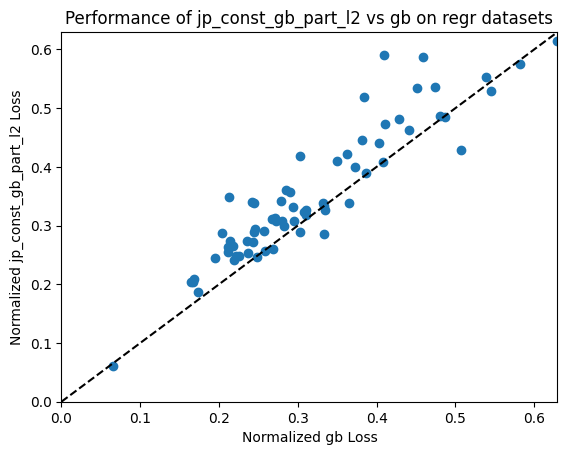

Probability jp_const_gb_part_l2 is equal/worse than gb: 4.0420882610123985e-09


In [11]:
# Focus on continuous features
compare_models("regr", "jp_const_gb_part_l2", "gb", FeatType.CONTINUOUS)

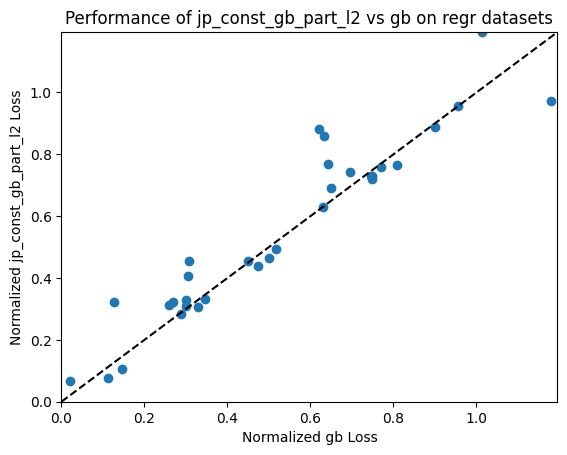

Probability jp_const_gb_part_l2 is equal/worse than gb: 0.111989387543872


In [12]:
# Focus on categorical features
compare_models("regr", "jp_const_gb_part_l2", "gb", FeatType.CATEGORICAL)

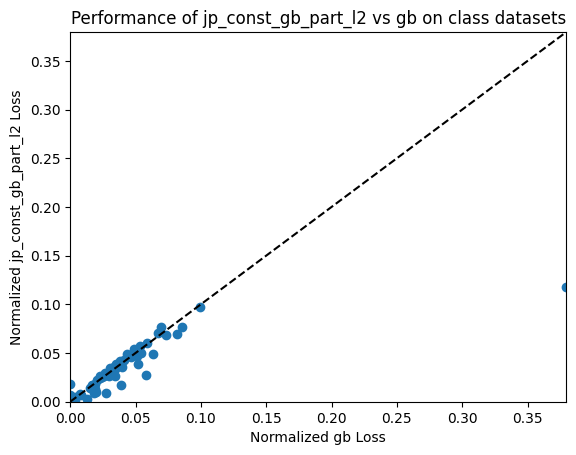

Probability jp_const_gb_part_l2 is equal/worse than gb: 0.6775001013723921


In [13]:
compare_models("class", "jp_const_gb_part_l2", "gb", FeatType.CATEGORICAL)

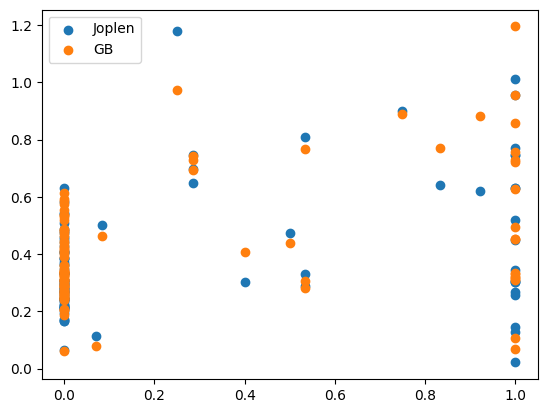

JOPLEN: 0.3436
GB: 0.3517


In [14]:
joplen_info = model_info["regr"]["jp_const_gb_part_l2"]
gb_info = model_info["regr"]["gb"]

shared_ds = set(joplen_info.keys()) & set(gb_info.keys())

joplen_perf = []
gb_perf = []

for ds in shared_ds:
    joplen_perf.append(joplen_info[ds]["test_score"] / joplen_info[ds]["dummy_loss"])
    gb_perf.append(gb_info[ds]["test_score"] / gb_info[ds]["dummy_loss"])

frac_categorical = np.array([dataset_info[ds]["frac_categorical"] for ds in shared_ds])

plt.scatter(frac_categorical, joplen_perf, label="Joplen")
plt.scatter(frac_categorical, gb_perf, label="GB")
plt.legend()
plt.show()

print(f"JOPLEN: {spearmanr(frac_categorical, joplen_perf).correlation:.4f}")
print(f"GB: {spearmanr(frac_categorical, gb_perf).correlation:.4f}")

# Seems that there is a weak positive correlation between the fraction of categorical features and the test score

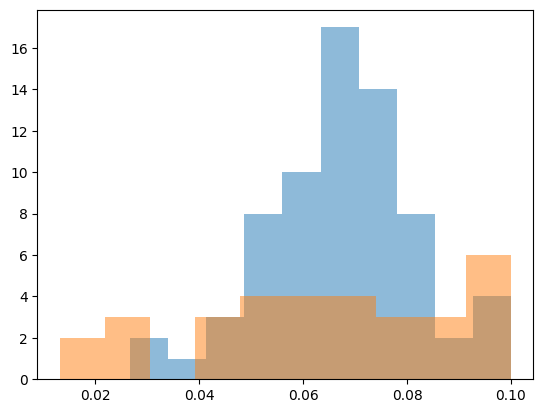

In [19]:
cont_lr = []
cat_lr = []
class_lr = []

for ds in shared_ds:
    lr = gb_info[ds]["params"]["learning_rate"]
    if dataset_info[ds]["is_classification"]:
        class_lr.append(lr)
    else:
        if dataset_info[ds]["contains_categorical"]:
            cat_lr.append(lr)
        else:
            cont_lr.append(lr)

plt.hist(cont_lr, alpha=0.5)
plt.hist(cat_lr, alpha=0.5)

plt.show()

# Seems that the truncated learning rate is not the issue, as it's more truncated
# on the categorical datasets, which perform better

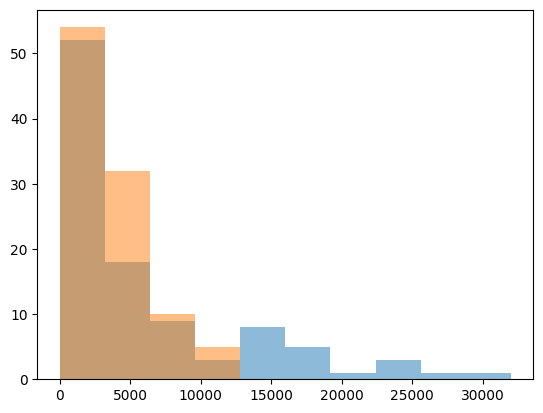

In [33]:
gb_n_cells = []
joplen_n_cells = []

joplen_info = model_info["regr"]["jp_const_gb_part_l2"]
gb_info = model_info["regr"]["gb"]

shared_ds = set(joplen_info.keys()) & set(gb_info.keys())

for ds in shared_ds:
    max_depth = gb_info[ds]["params"]["max_depth"]
    max_leaf_nodes = gb_info[ds]["params"]["max_leaf_nodes"]
    n_estimators = gb_info[ds]["params"]["n_estimators"]
    max_leaf_nodes = min(max_leaf_nodes, 2**max_depth)
    n_cells = max_leaf_nodes * n_estimators

    gb_n_cells.append(n_cells)

    n_leaves = joplen_info[ds]["params"]["n_cells"]
    n_partitions = joplen_info[ds]["params"]["n_partitions"]

    n_cells = n_leaves * n_partitions

    joplen_n_cells.append(n_cells)

max_n = max(*gb_n_cells, *joplen_n_cells)

plt.hist(joplen_n_cells, alpha=0.5, range=(0, max_n))
plt.hist(gb_n_cells, alpha=0.5, range=(0, max_n))

plt.show()

# Seems like joplen allows the model to use more cells in general?

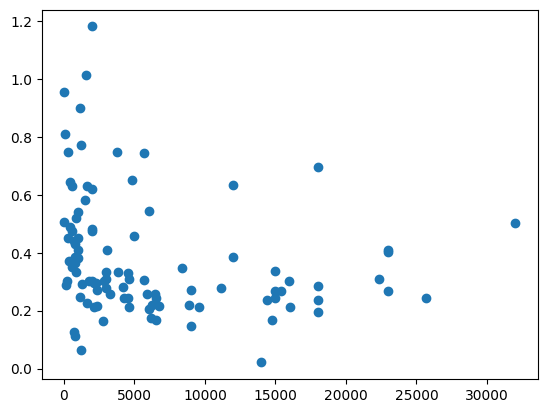

In [35]:
# doesn't seem to be a direct correlation between the number of cells and
# the performance...
plt.scatter(joplen_n_cells, joplen_perf, label="Joplen")

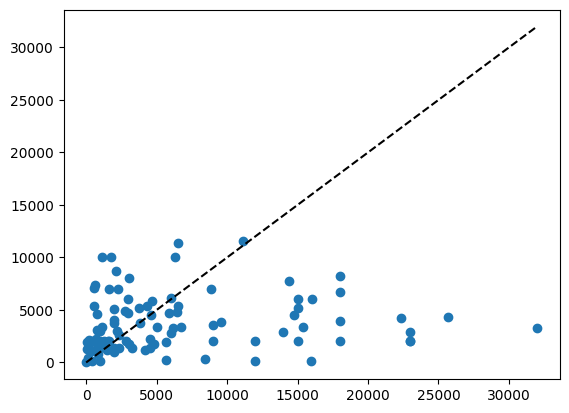

In [37]:
plt.plot([0, max_n], [0, max_n], "k--")
plt.scatter(joplen_n_cells, gb_n_cells)

In [5]:
fig = go.Figure()

continuous_ds = [ds for ds in shared_ds if not dataset_info[ds]["contains_categorical"]]

n_features = np.array([dataset_info[ds]["n_features"] for ds in continuous_ds])

# Adding Joplen performance
fig.add_trace(
    go.Scatter(
        x=n_features,
        y=joplen_perf,
        mode="markers",
        name="Joplen",
        text=list(continuous_ds),
        marker=dict(color="RoyalBlue"),
        hoverinfo="text+y",
    )
)

# Adding Gradient Boosting performance
fig.add_trace(
    go.Scatter(
        x=n_features,
        y=gb_perf,
        mode="markers",
        name="GB",
        text=list(continuous_ds),
        marker=dict(color="Crimson"),
        hoverinfo="text+y",
    )
)

# Updating layout for readability
fig.update_layout(
    title="Performance by Number of Features",
    xaxis_title="Number of Features",
    yaxis_title="Performance",
    legend_title="Algorithm",
)

# Show plot
fig.show()

KeyboardInterrupt: 

In [ ]:
small_ds = "192_vineyard"
small_ds_info = dataset_info[small_ds]

joplen_small_model_info = model_info["regr"]["jp_const_gb_part_l2"][small_ds]["params"]
gb_small_model_info = model_info["regr"]["gb"][small_ds]["params"]

joplen_small_model_info

In [ ]:
x_train = np.loadtxt(DS_PATH / "reg" / small_ds / "x_train.csv", delimiter=",")
y_train = np.loadtxt(DS_PATH / "reg" / small_ds / "y_train.csv", delimiter=",")

x_val = np.loadtxt(DS_PATH / "reg" / small_ds / "x_val.csv", delimiter=",")
y_val = np.loadtxt(DS_PATH / "reg" / small_ds / "y_val.csv", delimiter=",")

y_test = np.loadtxt(DS_PATH / "reg" / small_ds / "y_test.csv", delimiter=",")
x_test = np.loadtxt(DS_PATH / "reg" / small_ds / "x_test.csv", delimiter=",")

x_ss = StandardScaler().fit(x_train)
x_train = x_ss.transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

gb = GradientBoostingRegressor(**gb_small_model_info)
gb.fit(x_train, y_train)

params = deepcopy(joplen_small_model_info)

initial_params = {
    "partitioner": eval(params.pop("partitioner")),
    "n_cells": params.pop("n_cells"),
    "n_partitions": params.pop("n_partitions"),
    "random_state": params.pop("random_state"),
}

if "cell_model" in params:
    initial_params["cell_model"] = eval(params.pop("cell_model"))

if "norm_type" in params:
    params["norm_type"] = eval(params["norm_type"])

joplen = JOPLEn(
    loss_fn=SquaredError,
    **initial_params,
)

history = joplen.fit(
    x_train,
    y_train,
    val_x=x_val,
    val_y=y_val,
    **params,
)

In [ ]:
x_min, x_max = x_train[:, 0].min(), x_train[:, 0].max()
y_min, y_max = x_train[:, 1].min(), x_train[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

gb_pred = gb.predict(np.c_[xx.ravel(), yy.ravel()])
gb_pred = gb_pred.reshape(xx.shape)

joplen_pred = joplen.predict(np.c_[xx.ravel(), yy.ravel()])
joplen_pred = joplen_pred.reshape(xx.shape)
joplen_pred = joplen_pred

fig = go.Figure(data=[go.Surface(x=xx, y=yy, z=joplen_pred)])

surface1 = go.Surface(
    z=gb_pred, x=xx, y=yy, colorscale="Viridis", opacity=1.0, name="GB", showscale=False
)

# Create the second surface plot
surface2 = go.Surface(
    z=joplen_pred, x=xx, y=yy, colorscale="Magma", opacity=1.0, showscale=False
)

# train_points = go.Scatter3d(
#     x=x_train[:, 0],
#     y=x_train[:, 1],
#     z=y_train,
#     mode="markers",
#     marker=dict(color="black", size=5),
#     name="Train",
# )

# val_points = go.Scatter3d(
#     x=x_val[:, 0],
#     y=x_val[:, 1],
#     z=y_val,
#     mode="markers",
#     marker=dict(color="red", size=5),
#     name="Validation",
# )

test_points = go.Scatter3d(
    x=x_test[:, 0],
    y=x_test[:, 1],
    z=y_test,
    mode="markers",
    marker=dict(color="green", size=5),
    name="Test",
)

# Add both surfaces to the figure
fig = go.Figure(
    data=[
        surface1,
        surface2,
        # train_points,
        # val_points,
        test_points,
    ]
)

# Update layout for a better view
fig.update_layout(
    title="Overlayed Surfaces",
    autosize=False,
    width=700,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90),
)


# Show the plot
fig.show()